# Genre Prediction

## Reading Libraries

In [1]:
#Reading Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

## Data Preparation

In [2]:
#Reading Data
path = "./Data/Music_Genre/"
df= pd.read_csv(f'{path}music_data.csv')
df.rename(columns = {'Popularity':'popularity', 'duration_in min/ms':'duration_ms'}, inplace = True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist Name       17996 non-null  object 
 1   Track Name        17996 non-null  object 
 2   popularity        17568 non-null  float64
 3   danceability      17996 non-null  float64
 4   energy            17996 non-null  float64
 5   key               15982 non-null  float64
 6   loudness          17996 non-null  float64
 7   mode              17996 non-null  int64  
 8   speechiness       17996 non-null  float64
 9   acousticness      17996 non-null  float64
 10  instrumentalness  13619 non-null  float64
 11  liveness          17996 non-null  float64
 12  valence           17996 non-null  float64
 13  tempo             17996 non-null  float64
 14  duration_ms       17996 non-null  float64
 15  time_signature    17996 non-null  int64  
 16  Class             17996 non-null  int64 

In [4]:
num_cols = df.columns[2:]
print(num_cols)
df = df[num_cols]

Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'Class'],
      dtype='object')


In [5]:
#Feature Engineering
def add_log_features(df, features, drop = False):
    for f in features:
        df[f+'_log'] = np.log(df[f])
        if drop == True:
            df = df.drop([f], axis = 1)
    return df

In [6]:
#add log features
features = ['energy', 'duration_ms']
#new_df = add_log_features(df_train, features)
new_df = df

In [7]:
new_df.isnull().sum()

popularity           428
danceability           0
energy                 0
key                 2014
loudness               0
mode                   0
speechiness            0
acousticness           0
instrumentalness    4377
liveness               0
valence                0
tempo                  0
duration_ms            0
time_signature         0
Class                  0
dtype: int64

In [8]:
X = new_df.loc[:, new_df.columns != 'Class']
cols = X.columns
print(cols)
Y = new_df.Class
train_x, test_x, train_y, test_y = train_test_split(X, Y, random_state = 104, test_size = 0.1, shuffle=True)
print("Initial data: ", df.shape)
print("Shape of train_x: ", train_x.shape)
print("Shape of train_y: ", train_y.shape)
print("Shape of test_x: ", test_x.shape)
print("Shape of test_y: ", test_y.shape)

Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')
Initial data:  (17996, 15)
Shape of train_x:  (16196, 14)
Shape of train_y:  (16196,)
Shape of test_x:  (1800, 14)
Shape of test_y:  (1800,)


## Building Prediction Model

In [29]:
#XGBOOST MODEL
'''
dtrain = xgb.DMatrix(train_x, label = train_y, enable_categorical = True)
#params = {"max_depth": 2, "eta":0.1}
params = {"max_depth": 2, "eta":0.1}
model = xgb.cv(params, dtrain, num_boost_round = 500, early_stopping_rounds = 100)
'''
def build_xgb(train_x, train_y, test_x, test_y, n_estimators = 300, max_depth = 2, learning_rate = 0.1):
    model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    model.fit(train_x, train_y)
    preds = model.predict(test_x)
    acc = ((preds == test_y).sum().astype(float)/len(preds))*100
    print("n_estimators: ", n_estimators)
    print("max_depth: ", max_depth)
    print("learning_rate: ", learning_rate)
    print("Accuracy: ", acc)
    return model, acc

## Hyperparameter Tuning

In [10]:
#Hyperparameter Tuning1
max_depth_list = np.arange(3, 11)
n_estimators_list = np.arange(50, 400, 50)
learning_rate_list = np.linspace(0.01, 0.2, 10)
print(max_depth_list)
print(n_estimators_list)
print(learning_rate_list)

[ 3  4  5  6  7  8  9 10]
[ 50 100 150 200 250 300 350]
[0.01       0.03111111 0.05222222 0.07333333 0.09444444 0.11555556
 0.13666667 0.15777778 0.17888889 0.2       ]


In [11]:
#Hyperparameter Tuning2
i = 0
best_acc = 0
best_param = {}
best_model = None
for md in max_depth_list:
    for ne in n_estimators_list:
        for lr in learning_rate_list:
            print(f"model {i}")
            model, acc = build_xgb(train_x, train_y, test_x, test_y, n_estimators = ne, max_depth = md, learning_rate = lr)
            if acc > best_acc:
                best_param["max_depth"] = md
                best_param["n_estimators"] = ne
                best_param["learning_rate"] = lr
                best_acc = acc
                best_model = model
            i+=1

model 0
n_estimators:  50
max_depth:  3
learning_rate:  0.01
Accuracy:  50.22222222222222
model 1
n_estimators:  50
max_depth:  3
learning_rate:  0.03111111111111111
Accuracy:  53.0
model 2
n_estimators:  50
max_depth:  3
learning_rate:  0.052222222222222225
Accuracy:  53.5
model 3
n_estimators:  50
max_depth:  3
learning_rate:  0.07333333333333333
Accuracy:  53.61111111111111
model 4
n_estimators:  50
max_depth:  3
learning_rate:  0.09444444444444444
Accuracy:  54.61111111111111
model 5
n_estimators:  50
max_depth:  3
learning_rate:  0.11555555555555555
Accuracy:  54.833333333333336
model 6
n_estimators:  50
max_depth:  3
learning_rate:  0.1366666666666667
Accuracy:  55.00000000000001
model 7
n_estimators:  50
max_depth:  3
learning_rate:  0.1577777777777778
Accuracy:  55.388888888888886
model 8
n_estimators:  50
max_depth:  3
learning_rate:  0.1788888888888889
Accuracy:  55.666666666666664
model 9
n_estimators:  50
max_depth:  3
learning_rate:  0.2
Accuracy:  55.27777777777778
model 

In [12]:
#Result of Hyperparameter Tuning
print(f"best acc: {best_acc}")
print(f"best parameter: ", best_param)

best acc: 57.77777777777777
best parameter:  {'max_depth': 4, 'n_estimators': 250, 'learning_rate': 0.07333333333333333}


## Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

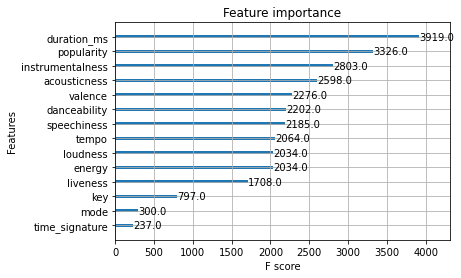

In [14]:
#feature importance of the model
plot_importance(best_model)

In [31]:
#Build model after dropping less important features
print(f'initial columns: {cols}')
drop_cols = ['time_signature']
new_cols = [col for col in cols if col not in drop_cols]
print(f'new columns: {new_cols}')
new_train_x = train_x[new_cols]
new_test_x = test_x[new_cols]

#tuned hyperparameters
n_estimators = 250
max_depth = 4
learning_rate = 0.07333333333333333

#build new model
model, acc = build_xgb(new_train_x, train_y, new_test_x, test_y, n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate)
print(f'Acc after dropping {drop_cols}: {acc}')

initial columns: Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')
new columns: ['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
n_estimators:  250
max_depth:  4
learning_rate:  0.07333333333333333
Accuracy:  56.94444444444444
Acc after dropping ['time_signature']: 56.94444444444444


After dropping the least important feature, the performance of the model slightly decreased from 57.77 to 56.94.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

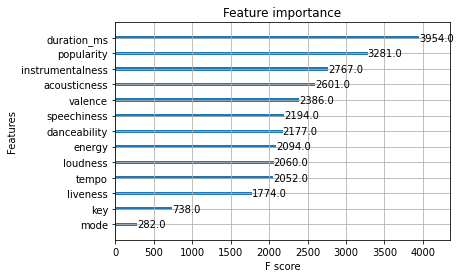

In [32]:
plot_importance(model)

In [33]:
#Build model after dropping less important features
print(f'initial columns: {cols}')
drop_cols = ['time_signature', 'mode']
new_cols = [col for col in cols if col not in drop_cols]
print(f'new columns: {new_cols}')
new_train_x = train_x[new_cols]
new_test_x = test_x[new_cols]

#tuned hyperparameters
n_estimators = 250
max_depth = 4
learning_rate = 0.07333333333333333

#build new model
model, acc = build_xgb(new_train_x, train_y, new_test_x, test_y, n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate)
print(f'Acc after dropping {drop_cols}: {acc}')

initial columns: Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')
new columns: ['popularity', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
n_estimators:  250
max_depth:  4
learning_rate:  0.07333333333333333
Accuracy:  57.05555555555556
Acc after dropping ['time_signature', 'mode']: 57.05555555555556


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

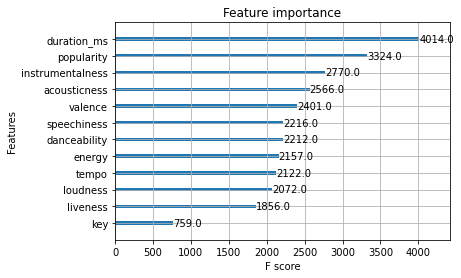

In [34]:
plot_importance(model)

In [35]:
#Build model after dropping less important features
print(f'initial columns: {cols}')
drop_cols = ['time_signature', 'mode', 'key']
new_cols = [col for col in cols if col not in drop_cols]
print(f'new columns: {new_cols}')
new_train_x = train_x[new_cols]
new_test_x = test_x[new_cols]

#tuned hyperparameters
n_estimators = 250
max_depth = 4
learning_rate = 0.07333333333333333

#build new model
model, acc = build_xgb(new_train_x, train_y, new_test_x, test_y, n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate)
print(f'Acc after dropping {drop_cols}: {acc}')

initial columns: Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')
new columns: ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
n_estimators:  250
max_depth:  4
learning_rate:  0.07333333333333333
Accuracy:  57.111111111111114
Acc after dropping ['time_signature', 'mode', 'key']: 57.111111111111114


In [36]:
#Build model after dropping less important features
print(f'initial columns: {cols}')
drop_cols = ['mode', 'key']
new_cols = [col for col in cols if col not in drop_cols]
print(f'new columns: {new_cols}')
new_train_x = train_x[new_cols]
new_test_x = test_x[new_cols]

#tuned hyperparameters
n_estimators = 250
max_depth = 4
learning_rate = 0.07333333333333333

#build new model
model, acc = build_xgb(new_train_x, train_y, new_test_x, test_y, n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate)
print(f'Acc after dropping {drop_cols}: {acc}')

initial columns: Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')
new columns: ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
n_estimators:  250
max_depth:  4
learning_rate:  0.07333333333333333
Accuracy:  57.111111111111114
Acc after dropping ['mode', 'key']: 57.111111111111114


The above models were built by dropping some of the least important features from the data. However, the performances of new models were not improved. So, all features were used to build the final model.

## Final Model

In [37]:
#Building final model
print(f'Used Features: {cols}')

#tuned hyperparameters
n_estimators = 250
max_depth = 4
learning_rate = 0.07333333333333333

#build new model
model, acc = build_xgb(new_train_x, train_y, new_test_x, test_y, n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate)
print(f'Acc after dropping {drop_cols}: {acc}')

Used Features: Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')
n_estimators:  250
max_depth:  4
learning_rate:  0.07333333333333333
Accuracy:  57.111111111111114
Acc after dropping ['mode', 'key']: 57.111111111111114


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

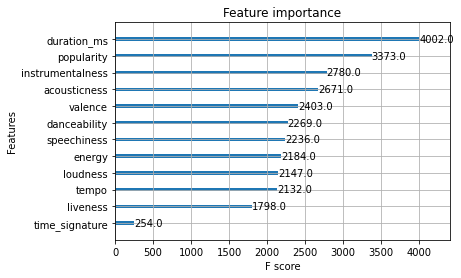

In [38]:
plot_importance(model)